<a href="https://colab.research.google.com/github/btran30/cs584/blob/brenda/Densenet201_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet 201 Analysis

## Library Import

In [7]:
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation,Flatten,MaxPooling2D,Dropout,UpSampling2D
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load and preprocess Data from Keras

In [8]:
def preprocess_data(num_classes):

    if num_classes == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    else :
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
    x_train = tensorflow.keras.applications.densenet.preprocess_input(x_train)
    x_test = tensorflow.keras.applications.densenet.preprocess_input(x_test)
    y_train = tensorflow.keras.utils.to_categorical(y_train)
    y_test = tensorflow.keras.utils.to_categorical(y_test)
       
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    return (x_train, y_train), (x_test, y_test) 

## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [14]:
def fit_model(num_classes, x_train, y_train, x_test, y_test):
    densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in densenet_model.layers:
      if isinstance(layer, BatchNormalization):
        layer.trainable = True  # update the weight
      else:
        layer.trainable = False
        
    model = Sequential()
    model.add(UpSampling2D(size=(7,7)))
    model.add(densenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

    datagen = ImageDataGenerator(rotation_range=8,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.05, 
                             horizontal_flip=True)
    datagen.fit(x_train)
    # Fits-the-model
    batch_size = 64
    epochs = 10
    anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint('Densenet201_cifar'+str(num_classes)+'.h5', verbose=1, save_best_only=True)

    t=time.time()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
               steps_per_epoch=x_train.shape[0] // batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=[anne,checkpoint],
               validation_data=(x_test, y_test))
    print('Training time: %s' % (time.time() -t))
    # model.save('Densenet201_cifar'+str(num_classes)+'.h5')
    return history, model

In [10]:
def summarize_diagnostics(num_classes, history):
    cifar = 'CIFAR'+str(num_classes)
    plt.subplots_adjust(hspace=0.7)
    # plot loss
    plt.subplot(211)
    plt.title(cifar + ' Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    plt.subplot(212)
    plt.title(cifar + ' Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    #filename = "DenseNet201_Pretrained"
    #plt.savefig(filename + '_plot.png')
    
    return history


In [11]:
def predict(model, x_test, y_test):
    ypred = model.predict(x_test)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1
    
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    return ypred

### Run with CIFAR100

In [15]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)
Epoch 1/2
781/781 [==============================] - ETA: 0s - loss: 1.6704 - accuracy: 0.5617 - top_k_categorical_accuracy: 0.8302
Epoch 00001: val_loss improved from inf to 1.03908, saving model to model.h5
781/781 [==============================] - 681s 872ms/step - loss: 1.6704 - accuracy: 0.5617 - top_k_categorical_accuracy: 0.8302 - val_loss: 1.0391 - val_accuracy: 0.6956 - val_top_k_categorical_accuracy: 0.9315
Epoch 2/2
142/781 [====>.........................] - ETA: 8:36 - loss: 0.9441 - accuracy: 0.7250 - top_k_categorical_accuracy: 0.9411

KeyboardInterrupt: ignored

### Run with CIFAR10

170500096/170498071 [==============================] - 4s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)
74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/10
781/781 [==============================] - 702s 899ms/step - loss: 0.3780 - accuracy: 0.8720 - top_k_categorical_accuracy: 0.9916 - val_loss: 0.1658 - val_accuracy: 0.9445 - val_top_k_categorical_accuracy: 0.9991
Epoch 2/10
781/781 [==============================] - 700s 896ms/step - loss: 0.1901 - accuracy: 0.9364 - top_k_categorical_accuracy: 0.9989 - val_loss: 0.1549 - val_accuracy: 0.9468 - val_top_k_categorical_accuracy: 0.9998
Epoch 3/10
781/781 [==============================] - 698s 893ms/step - loss: 0.1621 - accuracy: 0.9455 - top_k_categorical_accuracy: 0.9992 - val_loss: 0.1602 - val_accuracy: 0.9477 - val_top_k_categorical_accuracy: 0.9990
Epoch 4/10
781/781 [==============================] - 697s 893ms/step - loss: 0.1428 - accuracy: 0.9511 - top_k

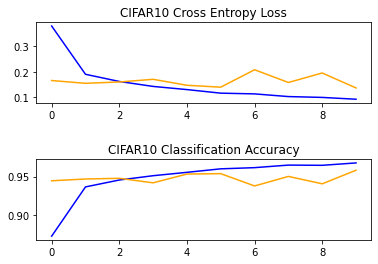

In [ ]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)